In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import os
from os import listdir
from skimage.transform import resize
from skimage.io import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from skimage.io import imread
import seaborn as sns
sns.set()
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

In [2]:
files = os.listdir("/Users/owenwebb/E90_data/archive-2/IDC_regular_ps50_idx5/")

In [3]:
base_path = "/Users/owenwebb/E90_data/archive-2/IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)
len(folder)

279

In [4]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)
        
total_images

277524

In [5]:
# Create a dataframe with columns = ["patient_id", "target", "path"]

target_arr=[]
datadir='/Users/owenwebb/E90_data/archive-2/IDC_regular_ps50_idx5'
patient_id_arr = []
path_arr = []

for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for img in range(len(subfiles)):
            image_path = subfiles[img]
            complete_path = os.path.join(class_path,image_path)
            target_arr.append(c)
            patient_id_arr.append(patient_id)
            path_arr.append(complete_path)
    
# flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
patient_id_np = np.array(patient_id_arr)
path_arr_np = np.array(path_arr)
data=pd.DataFrame()
data["target"]=target
data["patient_id"] = patient_id_np
data["path"] = path_arr_np

# This will create the x and y, but i need more complicated of a division
#x=data.iloc[:,:-1] #input data 
#y=data.iloc[:,-1] #output data

In [6]:
data.shape

(277524, 3)

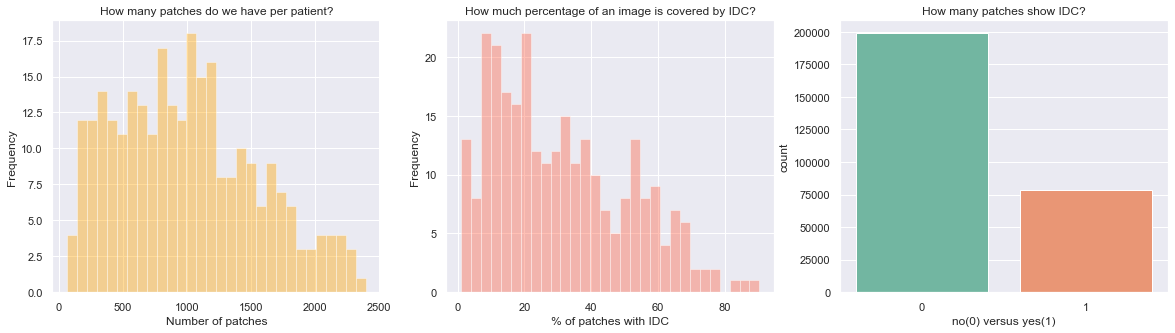

In [7]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

In [8]:
data.target = data.target.astype(np.int)

In [9]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

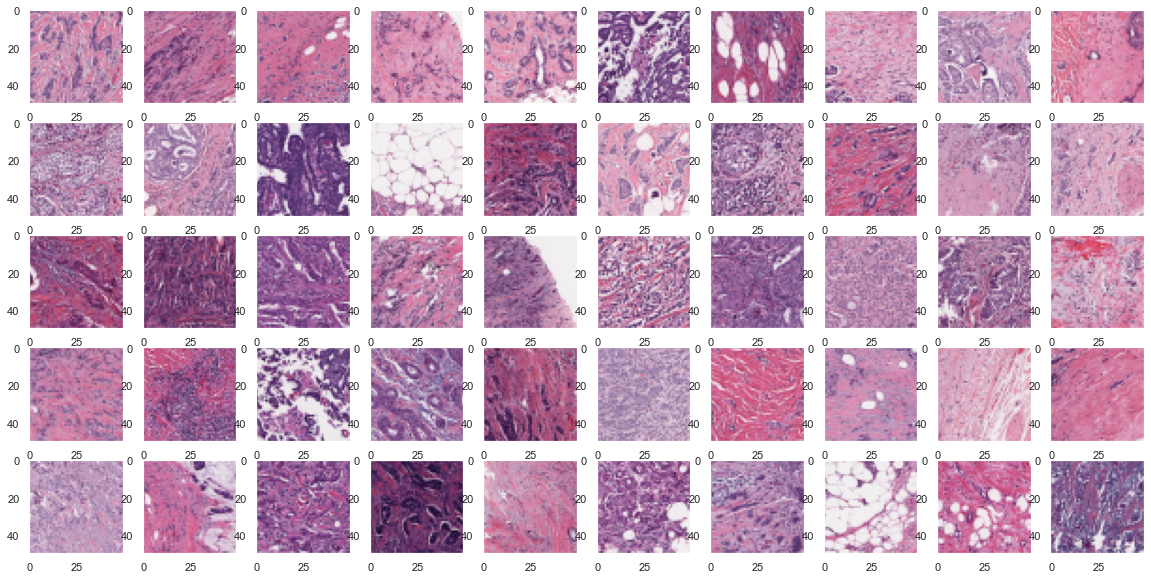

In [10]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

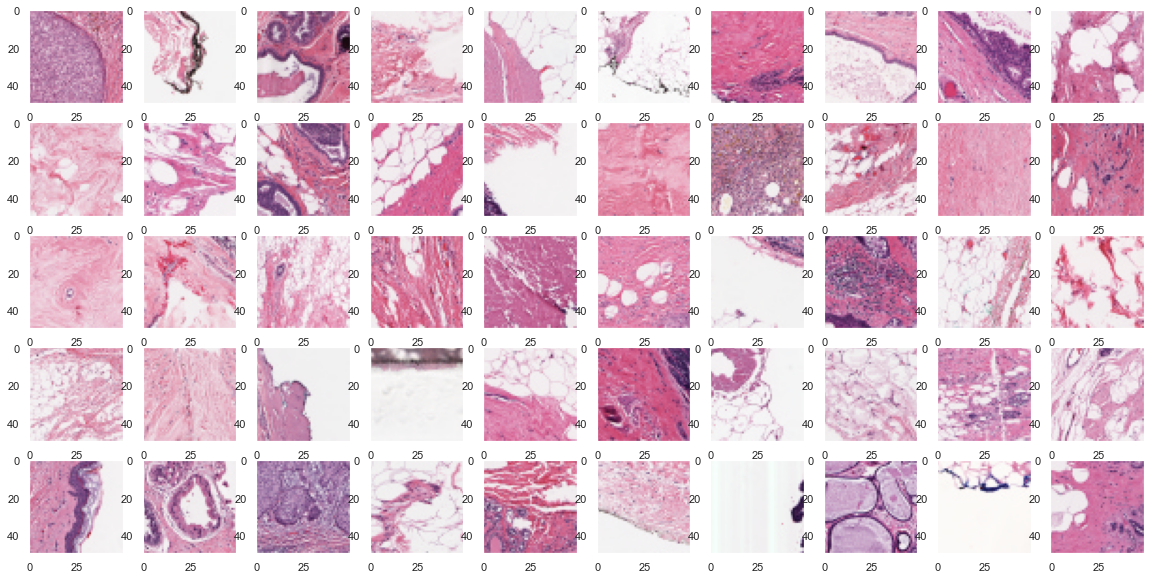

In [11]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [12]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

In [13]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

In [14]:


def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [15]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1051  2401       0  /Users/owenwebb/E90_data/archive-2/IDC_regular...
1  2951   951       0  /Users/owenwebb/E90_data/archive-2/IDC_regular...
2  3001  1451       0  /Users/owenwebb/E90_data/archive-2/IDC_regular...
3  3051   801       0  /Users/owenwebb/E90_data/archive-2/IDC_regular...
4   951  1901       0  /Users/owenwebb/E90_data/archive-2/IDC_regular...

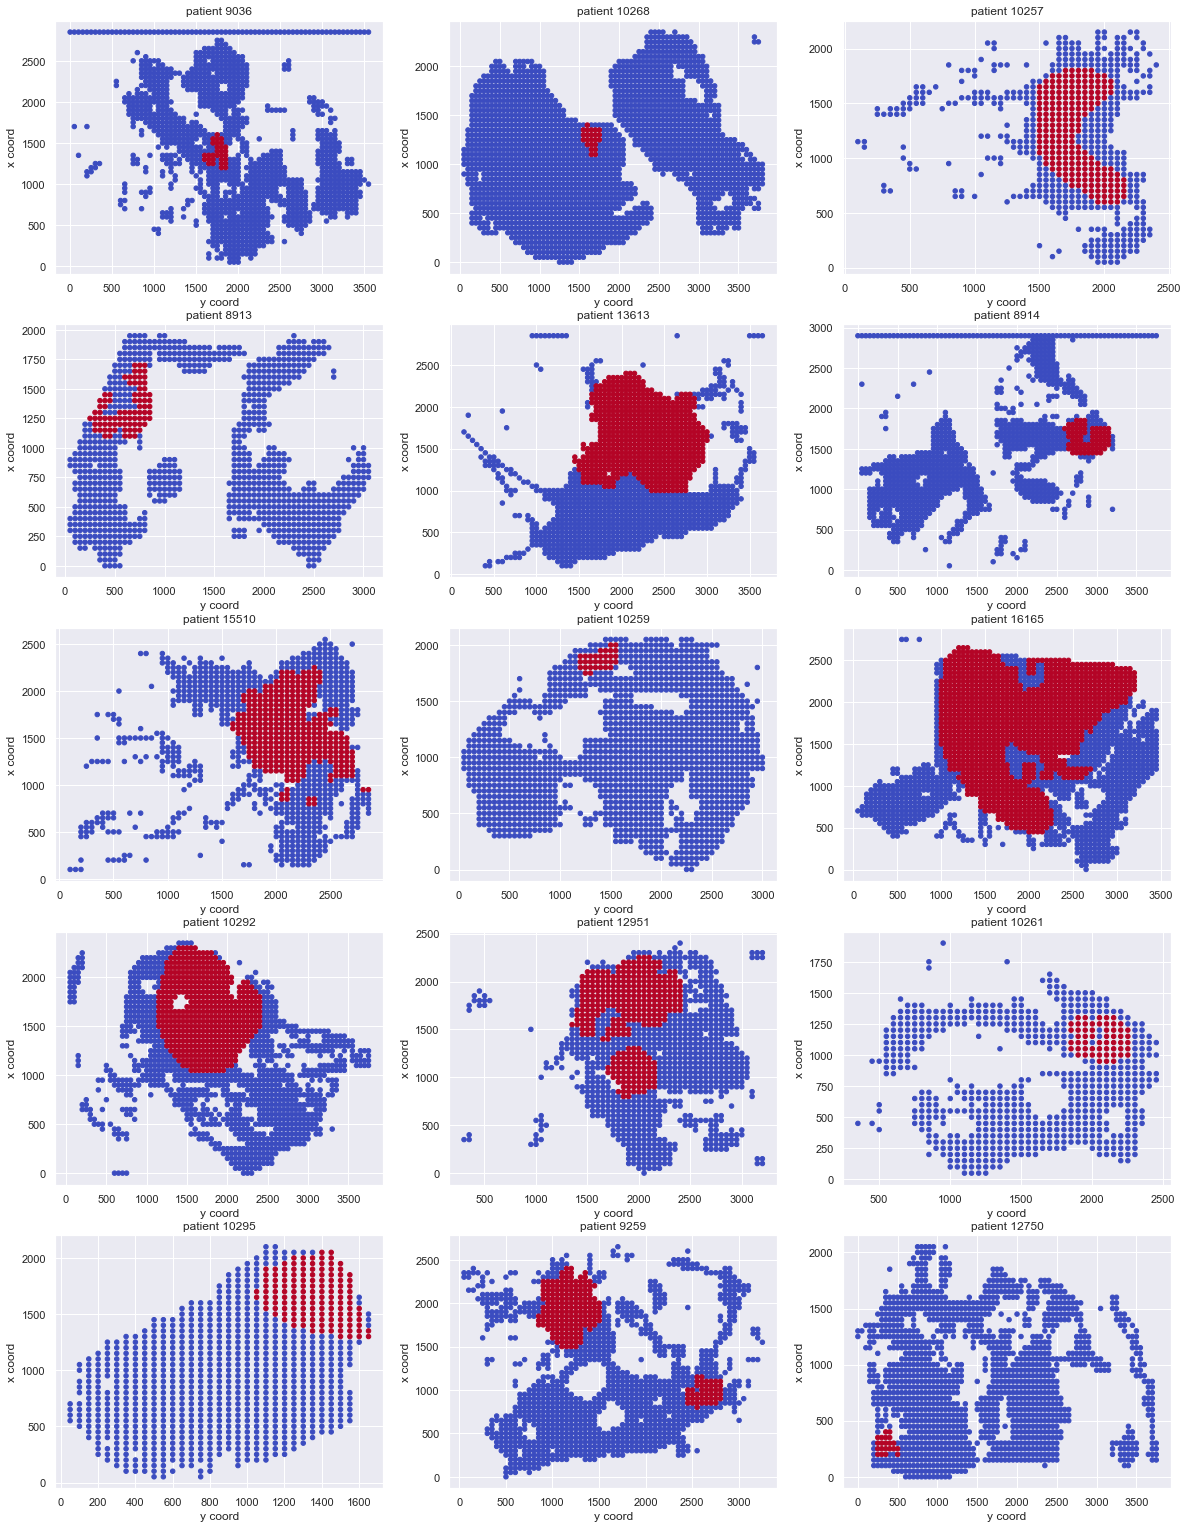

In [16]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

In [17]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

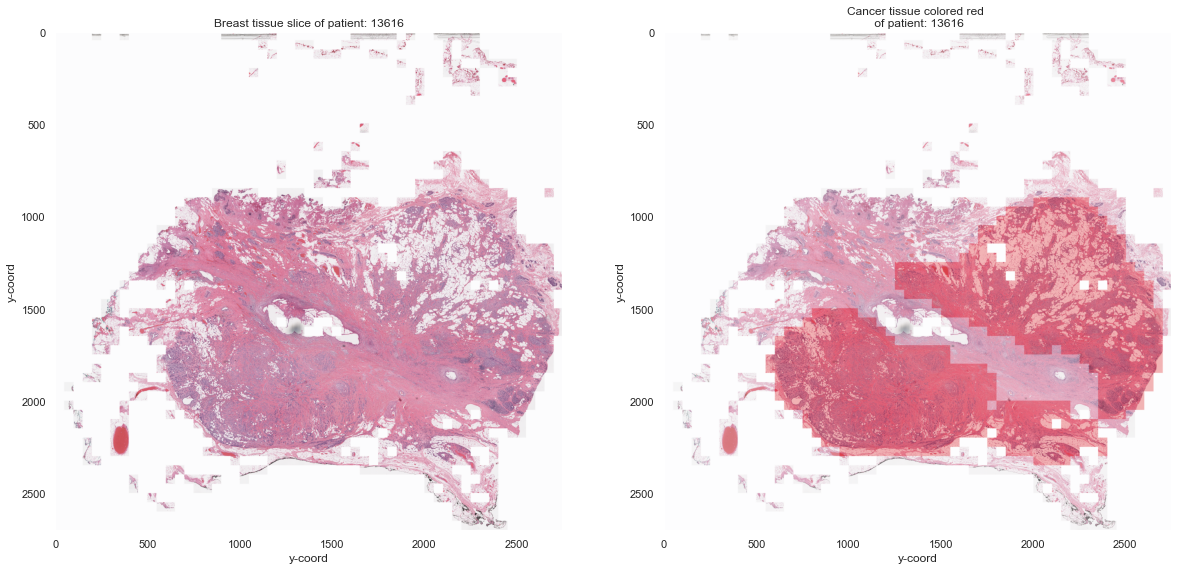

In [18]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + example)
ax[1].set_title("Cancer tissue colored red \n of patient: " + example);

In [19]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   target      277524 non-null  object
 1   patient_id  277524 non-null  object
 2   path        277524 non-null  object
dtypes: object(3)
memory usage: 6.4+ MB


In [20]:
import time

In [21]:
data.dtypes

target        object
patient_id    object
path          object
dtype: object

In [22]:
data["patient_id"] = data["patient_id"].astype(int)
data["target"] = data["target"].astype(int)

In [23]:
data.memory_usage(deep=True)

Index              128
target         2220192
patient_id     2220192
path          42672078
dtype: int64

In [ ]:
# Creats a numpy array of floats for each image
# This takes a long time roughly ~20min
start = time.time()
flat_data_arr = []

for img_path in data.path:
    img_array=imread(img_path)
    img_resized=resize(img_array,(50,50,3))
    flat_data_arr.append(img_resized.flatten())

flat_data=np.array(flat_data_arr, dtype=np.float)

end = time.time()
print("create flat data = %f" %(end-start))

In [ ]:
data.head()

In [ ]:
data = extract_coords(data)

In [ ]:
# creates a dataframe that contains the images as rows with features at columns
df = pd.DataFrame(flat_data)
df["target"] = data["target"]
df["patient_id"] = data["patient_id"]
df["x"] = data["x"]
df["y"] = data["y"]

In [ ]:
# del flat_data
# del flat_data_arr

In [ ]:
df.head()

In [ ]:
# split based on patient_id, so that we can train on all the x and y's
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [ ]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

In [ ]:
# divy up the data into a train, test, and dev dataframes
start = time.time()
train_df = df.loc[data.patient_id.isin(train_ids),:]
test_df = df.loc[data.patient_id.isin(test_ids),:]
dev_df = df.loc[data.patient_id.isin(dev_ids),:]
end = time.time()

In [ ]:
print("timing of df.loc = %f" %(end-start))

In [ ]:
# start_extract = time.time()
# train_df = extract_coords(train_df)
# test_df = extract_coords(test_df)
# dev_df = extract_coords(dev_df)
# end_extract = time.time()

In [ ]:
train_df.head()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(dev_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Dev data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

In [ ]:
# param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}

In [37]:
svc=svm.SVC(probability=True)

In [ ]:
# model=GridSearchCV(svc,param_grid,scoring='accuracy')

In [ ]:
svc.fit(train_df[train_df.columns.difference(["target","patient_id"])], train_df.target)

In [ ]:
# histogram of the features
# histogram of the positive and negative
# PCA could reduce 
# luminance and chromanance
# 8-bit pixel depth vs np.float
